In [ ]:
#Importing Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import preprocessing
%matplotlib inline
sns.set_style('whitegrid')
PATH='~/Downloads/Upgrad/ML-1/Linear Regression Module/Linear Regression Assignment/Data Files/'
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

# Step 1. Reading and Understanding the Data

In [ ]:
#Loading our dataset
carprice=pd.read_csv(PATH+'CarPrice_Assignment.csv')


In [ ]:
carprice.head()


In [ ]:
carprice.shape

In [ ]:
carprice.info()

In [ ]:
carDictionary=pd.read_excel(PATH+'Data Dictionary - carprices.xlsx')

In [ ]:
pd.set_option('display.max_colwidth', -1)
carDictionary

In [ ]:
#Checking if there is any missing data in the dataset
carprice.isna().sum()

In [ ]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

In [ ]:
# get some basic ideas about the data
def summarize_data(df):
    for column in df.columns:
        print (column)
        if df.dtypes[column] == np.object: # Categorical data
            print (df[column].value_counts())
        else:
            print (df[column].describe() )
            
        print ('\n')
    
summarize_data(carprice)

# Step 2: Cleaning and Visualizing the data

In [ ]:
#Creating a new variable company from CarName and doing some spelling corrections

carprice['Company']=carprice['CarName'].apply(lambda x: x.lower().split(' ')[0])
carprice['Company']=carprice['Company'].replace({'maxda':'mazda', 'toyouta': 'toyota', 'vokswagen':'volkswagen','vw':'volkswagen','porcshce':'porsche'})

In [ ]:
#Dropping CarID and CarName fields

carprice.drop('car_ID',axis=1,inplace=True)
carprice.drop('CarName',axis=1,inplace=True)


## UNIVARIATE ANANALYSIS

In [ ]:
#Plotting our target variable 'price'
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.distplot(carprice['price'])
plt.subplot(2,1,2)
sns.boxplot(carprice['price'])

Price of the car ranges around 5k-45k with Median around 10k

### Visualize the categorical variables: 
1. Symboling 
2. fueltype
2. aspiration
3. doornumber
4. carbody
5. drivewheel
6. enginelocation
7. enginetype
8. cylindernumber
9. fuelsystem
10. Company

In [ ]:
#Plotting categorical variables using Countplot and Boxplot
plt.figure(figsize=(20,100))
i=1
for col in carprice:
    if(carprice[col].dtypes==object):
        plt.subplot(10,2,i)
        ax=sns.countplot(carprice[col],palette='viridis')
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate('{:}'.format(height), (x+width/2-0.02, y + height+0.6))
        plt.xticks(rotation=90)
        plt.xlabel(col.capitalize())
        
        plt.subplot(10,2,i+1)
        sns.boxplot(carprice[col],carprice['price'],palette='viridis')
        plt.xticks(rotation=90)
        plt.xlabel(col.capitalize())
        plt.ylabel('Price')
        i+=2

# Step 3: Data Preparation

In [ ]:
#Converting Cylindernumber and door number to integer

carprice['cylindernumber']=carprice['cylindernumber'].replace({'two':2,'three':3,'four':4,'five':5,'six':6,'eight':8,'twelve':12})
carprice['doornumber']=carprice['doornumber'].replace({'two':2,'four':4})

### Checking the Correlation
We will not label encode the categorical variables and check the correlation between the variables

In [ ]:
# Encode the categorical features as numbers to check correlation
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result


# Calculate the correlation and plot it
encoded_data= number_encode_features(carprice)
plt.figure(figsize=(20,20))
sns.heatmap(abs(encoded_data.corr()), square=True,cmap='viridis')


We can see that there is a high correlation between fueltype and compression ratio, and , highwaympg and citympg. Lets check on this further.

In [ ]:
#Lets first analyse fueltype and compression ratio

print(carprice[["fueltype", "compressionratio"]])
sns.barplot("fueltype", "compressionratio",data=carprice,palette='viridis')

We can see the difference in the compression ratio between gas and diesel and clearly see why the columns have high correlation, we will drop compression ratio in our further analysis.

In [ ]:
#Dropping compressionratio
carprice.drop('compressionratio',axis=1,inplace=True)

In [ ]:
# Lets take a look at citympg and highwaympg variables
print(carprice[["citympg", "highwaympg"]])
sns.scatterplot("citympg", "highwaympg",data=carprice)

In [ ]:
#Dropping citympg as it is highly corelated with highwaympg
carprice.drop('citympg',axis=1,inplace=True)

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(abs(carprice.drop('price', axis=1).corr()),annot=True,cmap='viridis')
#Min Max Scaling of numerical columns in X_train


### Creating the dummy variables for categories

In [ ]:
#Creating dummy variables for categories 

varlist=['fueltype','aspiration','carbody','drivewheel','fuelsystem','enginetype','Company','doornumber'
         ,'enginelocation']

#Label Encoder- Symboling, doornumber, cylindernumber
carprice=pd.get_dummies(carprice,columns=varlist,prefix_sep='_',drop_first=True)


In [ ]:
carprice.head()

# Step 4: Splitting the data into train and test

In [ ]:
#Splitting the data into X_train and X_test

from sklearn.model_selection import train_test_split
X_train,X_test=train_test_split(carprice, test_size=0.3, random_state=100)

In [ ]:
#Checking the shape of X_train and X_test 

print(X_train.shape)
print(X_test.shape)

### Min Max scaling for our continuous variables

In [ ]:
#Min Max Scaling of numerical columns in X_train

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

mm_scaler_list=['wheelbase','carwidth','carheight','boreratio','stroke','horsepower','peakrpm',
         'highwaympg','symboling','cylindernumber','price']

X_train[mm_scaler_list]=scaler.fit_transform(X_train[mm_scaler_list])


### Separating the data into independent and predictor variables

In [ ]:
#Dividing X_test into X_test(independent variables) and y(dependent variable price)

y_train=X_train.pop('price')
X_train=X_train

In [ ]:
#importing  LinearRegression from SKLearn and creating an object and fitting the model with all variables

from sklearn.linear_model import LinearRegression
lm=LinearRegression()
lm.fit(X_train,y_train)

### Using RFE to select the top 15 significant features

In [ ]:
#Feature selection using RFE selecting the top 15 variables

from sklearn.feature_selection import RFE
rfe=RFE(lm,15)
rfe.fit(X_train, y_train)

In [ ]:
rfe.support_

In [ ]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

In [ ]:
X_train_rfe=X_train[X_train.columns[rfe.support_]]
X_train_rfe.head()

# Step 5 : Building our model

In [ ]:
#Creating our first model with 15 variables from RFE

X_train_rfe=sm.add_constant(X_train_rfe)
lr1=sm.OLS(y_train,X_train_rfe).fit()
lr1.summary()

We have got a low P(F-stats), so we have got a good model. Also, the adjust R-squared is 0.91 which is good as well. The P-value is less than 0.05 for all our variables which is ideal. Lets find the VIF now to avoid any multicollinearity issue.

In [45]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate the VIFs again for the new model
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0   const                83.42
8   carbody_sedan        12.74
7   carbody_hatchback    11.00
4   horsepower           7.83 
2   carwidth             7.32 
9   carbody_wagon        6.49 
1   wheelbase            5.18 
5   highwaympg           4.52 
3   cylindernumber       3.56 
14  Company_porsche      3.39 
15  enginelocation_rear  2.70 
6   carbody_hardtop      2.46 
10  enginetype_dohcv     2.42 
11  enginetype_rotor     1.65 
13  Company_buick        1.53 
12  Company_bmw          1.21

We can see that carbody_sedan has a high VIF, lets remove the variable and check our model.

In [46]:
#Creating our second model after dropping carbody_sedan as it has high VIF value
X_train_rfe.drop('carbody_sedan', axis=1,inplace=True)
lr2=sm.OLS(y_train,X_train_rfe).fit()
lr2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     88.14
Date:                Wed, 27 May 2020   Prob (F-statistic):           1.38e-58
Time:                        11:48:35   Log-Likelihood:                 186.02
No. Observations:                 143   AIC:                            -342.0
Df Residuals:                     128   BIC:                            -297.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.2088      0.047     -4.399      0.000      -0.303      -0.115
wheelbase               0.1589      0.060      2.650      0.009       0.040       0.277
carwidth                0.2917      0.085      3.418      0.001       0.123       0.461
cylindernumber          0.2222      0.095      2.334      0.021       0.034       0.411
horsepower              0.5870      0.099      5.957      0.000       0.392       0.782
highwaympg              0.0889      0.064      1.398      0.164      -0.037       0.215
carbody_hardtop        -0.0195      0.050     -0.387      0.700      -0.119       0.080
carbody_hatchback      -0.0373      0.015     -2.543      0.012      -0.066      -0.008
carbody_wagon          -0.0249      0.019     -1.311      0.192      -0.062       0.013
enginetype_dohcv       -0.3054      0.109     -2.814      0.006      -0.520      -0.091
enginetype_rotor        0.1206      0.045      2.681      0.008       0.032       0.210
Company_bmw             0.2409      0.032      7.526      0.000       0.178       0.304
Company_buick           0.2227      0.038      5.848      0.000       0.147       0.298
Company_porsche         0.1744      0.075      2.336      0.021       0.027       0.322
enginelocation_rear     0.2254      0.115      1.963      0.052      -0.002       0.453
==============================================================================
Omnibus:                       42.488   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.338
Skew:                           1.219   Prob(JB):                     9.88e-23
Kurtosis:                       6.326   Cond. No.                         34.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After removing the carbody_sedan, the model P(F-stat) is still very low. The adjusted R-square is 0.89 which is still a good number for the model. But certain variables including carbody_hardtop, carbody_wagon, highwaympg, enginelocation_rear have become significant. Lets remove the variable 'carbody_hardtop' and build our model again.

In [47]:
#Creating our third model after dropping carbody_hardtop as it has high P value

X_train_rfe.drop('carbody_hardtop', axis=1,inplace=True)
lr3=sm.OLS(y_train,X_train_rfe).fit()
lr3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     95.54
Date:                Wed, 27 May 2020   Prob (F-statistic):           1.49e-59
Time:                        11:48:35   Log-Likelihood:                 185.94
No. Observations:                 143   AIC:                            -343.9
Df Residuals:                     129   BIC:                            -302.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.2099      0.047     -4.446      0.000      -0.303      -0.117
wheelbase               0.1582      0.060      2.649      0.009       0.040       0.276
carwidth                0.2942      0.085      3.469      0.001       0.126       0.462
cylindernumber          0.2244      0.095      2.368      0.019       0.037       0.412
horsepower              0.5841      0.098      5.964      0.000       0.390       0.778
highwaympg              0.0882      0.063      1.393      0.166      -0.037       0.214
carbody_hatchback      -0.0366      0.014     -2.523      0.013      -0.065      -0.008
carbody_wagon          -0.0242      0.019     -1.287      0.200      -0.062       0.013
enginetype_dohcv       -0.3052      0.108     -2.822      0.006      -0.519      -0.091
enginetype_rotor        0.1209      0.045      2.697      0.008       0.032       0.210
Company_bmw             0.2415      0.032      7.580      0.000       0.178       0.305
Company_buick           0.2223      0.038      5.859      0.000       0.147       0.297
Company_porsche         0.1742      0.074      2.341      0.021       0.027       0.321
enginelocation_rear     0.2076      0.105      1.981      0.050       0.000       0.415
==============================================================================
Omnibus:                       42.936   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.868
Skew:                           1.230   Prob(JB):                     4.60e-23
Kurtosis:                       6.348   Cond. No.                         34.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our R-square has not dropped much but we still have some variables with high P value,which means that some variables are still pretty significant. We will drop carbody_wagon and build our model the fourth time.

In [48]:
#Creating our fourth model after dropping carbody_wagon as it has high VIF

X_train_rfe.drop('carbody_wagon', axis=1,inplace=True)
lr4=sm.OLS(y_train,X_train_rfe).fit()
lr4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     102.8
Date:                Wed, 27 May 2020   Prob (F-statistic):           3.24e-60
Time:                        11:48:35   Log-Likelihood:                 185.03
No. Observations:                 143   AIC:                            -344.1
Df Residuals:                     130   BIC:                            -305.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.2275      0.045     -5.023      0.000      -0.317      -0.138
wheelbase               0.1452      0.059      2.461      0.015       0.028       0.262
carwidth                0.3143      0.084      3.761      0.000       0.149       0.480
cylindernumber          0.2259      0.095      2.378      0.019       0.038       0.414
horsepower              0.5943      0.098      6.072      0.000       0.401       0.788
highwaympg              0.1047      0.062      1.684      0.095      -0.018       0.228
carbody_hatchback      -0.0323      0.014     -2.284      0.024      -0.060      -0.004
enginetype_dohcv       -0.3173      0.108     -2.938      0.004      -0.531      -0.104
enginetype_rotor        0.1239      0.045      2.759      0.007       0.035       0.213
Company_bmw             0.2479      0.032      7.858      0.000       0.185       0.310
Company_buick           0.2210      0.038      5.811      0.000       0.146       0.296
Company_porsche         0.1689      0.074      2.268      0.025       0.022       0.316
enginelocation_rear     0.2130      0.105      2.029      0.045       0.005       0.421
==============================================================================
Omnibus:                       45.865   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.444
Skew:                           1.300   Prob(JB):                     1.41e-25
Kurtosis:                       6.528   Cond. No.                         34.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our R-square has not dropped after dropping 'carbody_wagon' but we still have some variables with high P value. We will drop highwaympg and build our model the fourth time.

In [49]:
#Creating our fifth model after dropping highwaympg as it has high P-value

X_train_rfe.drop('highwaympg', axis=1,inplace=True)
lr5=sm.OLS(y_train,X_train_rfe).fit()
lr5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     110.4
Date:                Wed, 27 May 2020   Prob (F-statistic):           1.21e-60
Time:                        11:48:35   Log-Likelihood:                 183.48
No. Observations:                 143   AIC:                            -343.0
Df Residuals:                     131   BIC:                            -307.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1627      0.024     -6.768      0.000      -0.210      -0.115
wheelbase               0.1300      0.059      2.213      0.029       0.014       0.246
carwidth                0.3055      0.084      3.636      0.000       0.139       0.472
cylindernumber          0.2565      0.094      2.733      0.007       0.071       0.442
horsepower              0.4898      0.076      6.425      0.000       0.339       0.641
carbody_hatchback      -0.0289      0.014     -2.052      0.042      -0.057      -0.001
enginetype_dohcv       -0.2586      0.103     -2.512      0.013      -0.462      -0.055
enginetype_rotor        0.1080      0.044      2.443      0.016       0.021       0.195
Company_bmw             0.2482      0.032      7.812      0.000       0.185       0.311
Company_buick           0.2161      0.038      5.660      0.000       0.141       0.292
Company_porsche         0.1743      0.075      2.326      0.022       0.026       0.323
enginelocation_rear     0.2273      0.105      2.158      0.033       0.019       0.436
==============================================================================
Omnibus:                       48.683   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.253
Skew:                           1.356   Prob(JB):                     8.57e-29
Kurtosis:                       6.787   Cond. No.                         31.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our R-square is still pretty much the same after dropping 'highway_mpg'. The p-value for all variables is less than 0.05, which means all the variables are significant now. Lets check the VIF to check for multicollinearity.

In [50]:
# Calculate the VIFs again for the new model

vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0   const                16.83
2   carwidth             6.95 
4   horsepower           4.60 
1   wheelbase            4.21 
3   cylindernumber       3.42 
10  Company_porsche      3.36 
11  enginelocation_rear  2.24 
6   enginetype_dohcv     2.14 
7   enginetype_rotor     1.55 
9   Company_buick        1.43 
5   carbody_hatchback    1.30 
8   Company_bmw          1.18

We can see that the VIF of carwidth is 6.95 which is pretty significant, we will drop this variable and build out model again.

In [51]:
#Creating our sixth model after dropping carwidth as it has high VIF

X_train_rfe.drop('carwidth', axis=1,inplace=True)
lr6=sm.OLS(y_train,X_train_rfe).fit()
lr6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     109.9
Date:                Wed, 27 May 2020   Prob (F-statistic):           5.81e-59
Time:                        11:48:35   Log-Likelihood:                 176.61
No. Observations:                 143   AIC:                            -331.2
Df Residuals:                     132   BIC:                            -298.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1255      0.023     -5.519      0.000      -0.171      -0.081
wheelbase               0.2946      0.039      7.538      0.000       0.217       0.372
cylindernumber          0.2796      0.098      2.856      0.005       0.086       0.473
horsepower              0.6192      0.070      8.787      0.000       0.480       0.759
carbody_hatchback      -0.0302      0.015     -2.052      0.042      -0.059      -0.001
enginetype_dohcv       -0.2664      0.108     -2.476      0.015      -0.479      -0.054
enginetype_rotor        0.1270      0.046      2.770      0.006       0.036       0.218
Company_bmw             0.2210      0.032      6.846      0.000       0.157       0.285
Company_buick           0.2614      0.038      6.929      0.000       0.187       0.336
Company_porsche         0.2414      0.076      3.180      0.002       0.091       0.392
enginelocation_rear     0.1313      0.107      1.232      0.220      -0.080       0.342
==============================================================================
Omnibus:                       31.282   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.772
Skew:                           0.958   Prob(JB):                     2.34e-14
Kurtosis:                       5.620   Cond. No.                         28.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dropping the carwidth has decrease the significance of some variable as they have high P-value. We will drop enginelocation_rear and build our model again.

In [52]:
#Creating our seventh model after dropping horsepower as it has high P value

X_train_rfe.drop('enginelocation_rear', axis=1,inplace=True)
lr7=sm.OLS(y_train,X_train_rfe).fit()
lr7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     121.5
Date:                Wed, 27 May 2020   Prob (F-statistic):           1.08e-59
Time:                        11:48:35   Log-Likelihood:                 175.79
No. Observations:                 143   AIC:                            -331.6
Df Residuals:                     133   BIC:                            -301.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1241      0.023     -5.453      0.000      -0.169      -0.079
wheelbase             0.2870      0.039      7.423      0.000       0.211       0.363
cylindernumber        0.2845      0.098      2.903      0.004       0.091       0.478
horsepower            0.6266      0.070      8.907      0.000       0.487       0.766
carbody_hatchback    -0.0333      0.015     -2.290      0.024      -0.062      -0.005
enginetype_dohcv     -0.3337      0.093     -3.595      0.000      -0.517      -0.150
enginetype_rotor      0.1291      0.046      2.810      0.006       0.038       0.220
Company_bmw           0.2194      0.032      6.790      0.000       0.155       0.283
Company_buick         0.2612      0.038      6.911      0.000       0.186       0.336
Company_porsche       0.3032      0.057      5.313      0.000       0.190       0.416
==============================================================================
Omnibus:                       29.132   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.758
Skew:                           0.913   Prob(JB):                     7.80e-13
Kurtosis:                       5.454   Cond. No.                         23.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We have got a pretty good F stats and adjusted R-square. All the variables are also significant now. Lets check the VIF for multicollinearity.

In [53]:
# Calculate the VIFs again for the new model

vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0  const              13.75
3  horsepower         3.57 
2  cylindernumber     3.40 
9  Company_porsche    1.78 
1  wheelbase          1.67 
5  enginetype_dohcv   1.59 
6  enginetype_rotor   1.52 
8  Company_buick      1.28 
4  carbody_hatchback  1.27 
7  Company_bmw        1.11

The VIF is now less than 5 for all our variables which means we have a good model now. We will predict the values for the y_train and do the residual analysis now.

## Residual Analysis

In [54]:
#Finding the predicted y_train for our model

y_train_predict=lr7.predict(X_train_rfe)

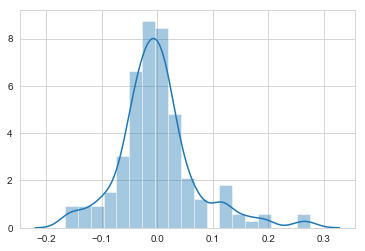

In [55]:
#Residual analysis
sns.distplot(y_train-y_train_predict)

THe graph seems to follow a normal distribution around 0. Our assumption that the error term is normally ditributed around 0 is valid for our model. We will now validate if our error is random or not.

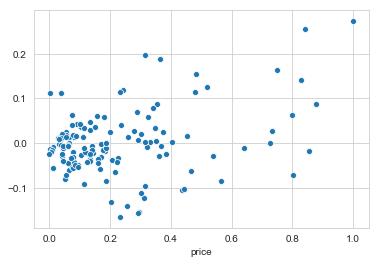

In [56]:
sns.scatterplot(y_train,y_train-y_train_predict)

Our error term are pretty random. So this proved our assumptions for linear regression regarding the error terms. <br>
Next, we will predict the values on our unseen data X_test.

# Step 6: Making predictions to the test set using our model

In [57]:
#Copying X_test to a new variable X_test_rfe
X_test_rfe=X_test.copy()

### Scaling our Test set

In [58]:
#Min Max Scaling of numerical columns in X_test_rfe

X_test_rfe[mm_scaler_list]=scaler.transform(X_test_rfe[mm_scaler_list])

### Splitting our Test set into Independent and Predictor variable

In [59]:
#Transforming X_test for model prediction and creating y_test

varlist=list(X_train_rfe.columns[1:,])
y_test_rfe=X_test_rfe.pop('price')
X_test_rfe=X_test_rfe[varlist]


In [60]:
#Adding constant to our test set and making the predictions.
X_test_rfe=sm.add_constant(X_test_rfe)

y_test_predict=lr7.predict(X_test_rfe)

Text(0, 0.5, 'y_pred')

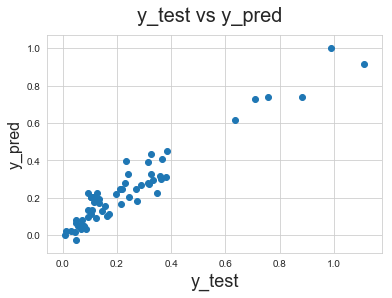

In [61]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test_rfe,y_test_predict,cmap='viridis')
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

### Checking our model accuracy

In [62]:
# Lets check our r2 score for the test set.
import sklearn.metrics as metrics
metrics.r2_score(y_test_rfe,y_test_predict)

0.9192117391372214

R2 score is 0.91 which is pretty similar to our model's R square which is 0.89. Lets build a scatterplot to see our initial and predicted  predictor variable.

In [63]:
#Printing MAR, MSE and RMSE

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_rfe,y_test_predict))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_rfe,y_test_predict))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_rfe,y_test_predict)))

Mean Absolute Error: 0.050725957348159934
Mean Squared Error: 0.0043179899427575295
Root Mean Squared Error: 0.06571141409799008


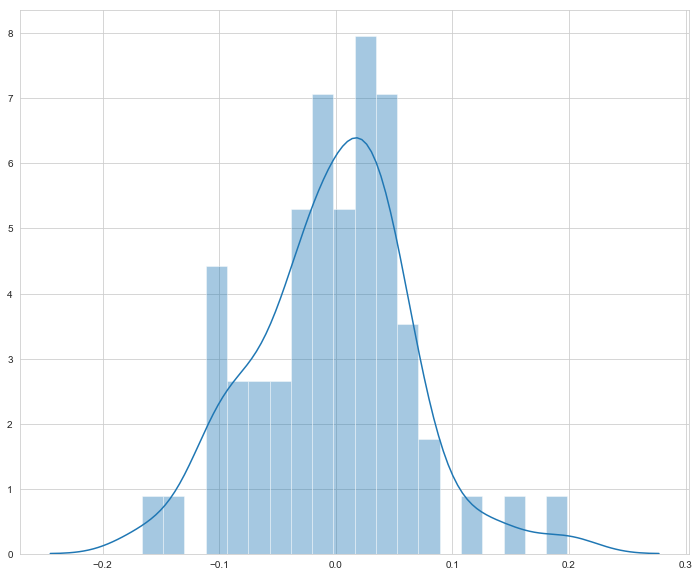

In [64]:
#Plotting the error terms
plt.figure(figsize=(12,10))
sns.distplot(y_test_rfe-y_test_predict,bins=20,)

We can see that the error term is normally distributed around zero, which means our model has done good predictions.

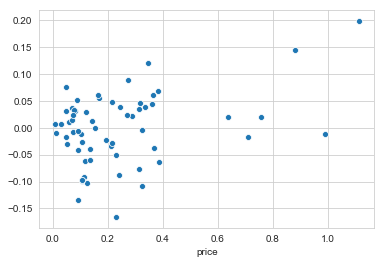

In [65]:
sns.scatterplot(y_test_rfe,y_test_rfe-y_test_predict)

Our error term are also randomly distributed on the test set which means that our model has done well on the unseen data.

### Checking the significance of our Independent variables

horsepower           0.626624
Company_porsche      0.303185
wheelbase            0.286992
cylindernumber       0.284464
Company_buick        0.261213
Company_bmw          0.219370
enginetype_rotor     0.129062
carbody_hatchback   -0.033323
enginetype_dohcv    -0.333741
dtype: float64


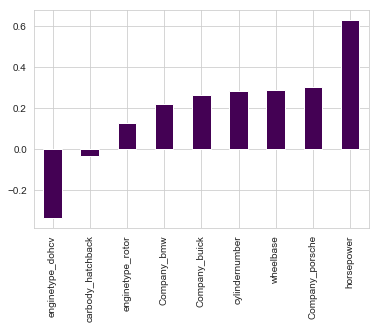

In [66]:
coefs = lr7.params[1:].sort_values()
plt.subplot(1,1,1)
coefs.plot(kind="bar",cmap='viridis')
print (coefs.sort_values(ascending = False))

Horsepower affects our target variable the most while enginetype_dohcv has the most negative effect on our target variable. Below is the equation of the best fit line identified thorugh our analysis.

In [67]:
#Equation of the Best fit line
print("Equation of the Best-fit line: \n")
for index,value in lr7.params.items():
    if(index=='const'):
        print('Price = ({0}'.format(round(value,2)),end =") + ")
    elif(index=='Company_porsche'):
        print('({0} * '.format(round(value,2))+index+")")
    else:
        print('({0} * '.format(round(value,2))+index,end =") + ")

Equation of the Best-fit line: 

Price = (-0.12) + (0.29 * wheelbase) + (0.28 * cylindernumber) + (0.63 * horsepower) + (-0.03 * carbody_hatchback) + (-0.33 * enginetype_dohcv) + (0.13 * enginetype_rotor) + (0.22 * Company_bmw) + (0.26 * Company_buick) + (0.3 * Company_porsche)


In [68]:
# sm.qqplot_2samples(y_test_rfe,y_train)

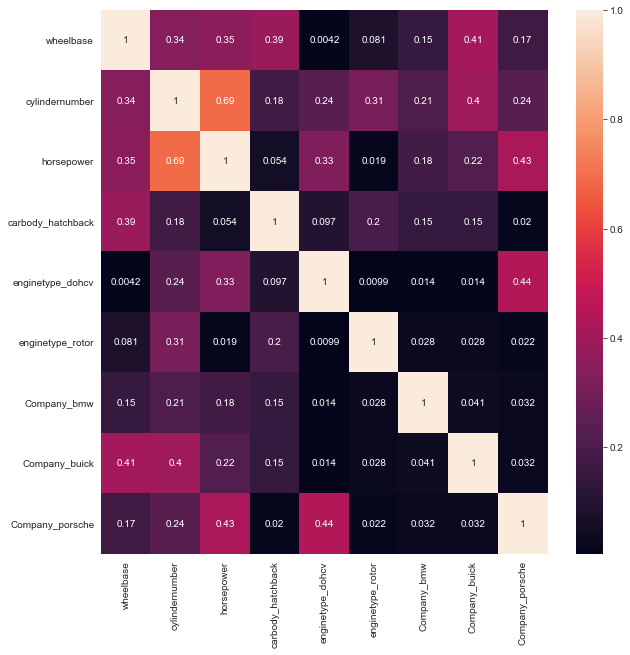

In [74]:
plt.figure(figsize=(10,10))
sns.heatmap(abs(carprice[varlist].corr()),annot=True)